# In Depth: Linear Regression

## Linear Regression Basics

In [2]:
library(AmesHousing) 
library(tidyverse) 
ames <- make_ordinal_ames()
ames <- ames %>%
 mutate(Bonus = ifelse(Sale_Price > 175000, 1, 0))

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# doing this to create an identical CSV to work from in Python

set.seed(123)

ames <- ames %>% mutate(id = row_number())

train <- ames %>% sample_frac(0.7)

test <- anti_join(ames, train, by = 'id')

write.csv(ames,"ames.csv", row.names = FALSE)
write.csv(train,"ames_train.csv", row.names = FALSE)
write.csv(test,"ames_test.csv", row.names = FALSE)

In [4]:
logit.model <- glm(Bonus ~ Gr_Liv_Area + factor(Central_Air), 
 data = ames, family = binomial(link = 'logit')) 
summary(logit.model)


Call:
glm(formula = Bonus ~ Gr_Liv_Area + factor(Central_Air), family = binomial(link = "logit"), 
    data = ames)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.102e+01  5.800e-01 -19.007   <2e-16 ***
Gr_Liv_Area           4.341e-03  1.707e-04  25.431   <2e-16 ***
factor(Central_Air)Y  4.288e+00  4.664e-01   9.195   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3983.5  on 2929  degrees of freedom
Residual deviance: 2529.9  on 2927  degrees of freedom
AIC: 2535.9

Number of Fisher Scoring iterations: 6


### Odds Ratio

In [5]:
exp( 
 cbind(coef(logit.model), confint(logit.model))
 )

Waiting for profiling to be done...



,,2.5 %,97.5 %
(Intercept),1.629599e-05,4.901624e-06,4.809789e-05
Gr_Liv_Area,1.004351e+00,1.004022e+00,1.004694e+00
factor(Central_Air)Y,7.285073e+01,3.107955e+01,1.967028e+02


### Likelihood Ratio Test for Ames Dataset

In [6]:
logit.model.r <- glm(Bonus ~ 1,
 data = ames, family = binomial(link = 'logit'))

#not an anova, just a likelihood test. but this is the syntax
anova(logit.model, logit.model.r, test = 'LRT')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2927,2529.895,NA,NA,NA
2,2929,3983.512,-2,-1453.617,2.243828e-316


### Check LRT with Fireplaces - use this for Categorical Variables with multiple levels (gives you one p-value)

#### Interpretation:
- first line: p-value for the full model with target variable.
- second line: leaves out Central Air (2 categorical variables)
- third line: leaves out Fireplaces (5 categorical variables)

- note: little a ANOVA can compare anything as long as its nested, big A ANOVA is full model minus one at a time

In [7]:
logit.model.f <- glm(Bonus ~ Gr_Liv_Area + 
 factor(Central_Air) + 
factor(Fireplaces),
 data = ames, family = binomial(link = 'logit'))

#here's the big A ANOVA. Use type III. Compares full model, with the model that drops the indicated varaible.
car::Anova(logit.model.f, test = 'LR', type = 'III')

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Gr_Liv_Area,868.21567,1,7.970593e-191
factor(Central_Air),127.03191,1,1.828102e-29
factor(Fireplaces),96.22934,4,6.241294e-20


### Checking the Assumption of Linearity for CONT Vars, using a General Additive Model (GAM)

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.




Family: binomial 
Link function: logit 

Formula:
Bonus ~ s(Gr_Liv_Area) + factor(Central_Air)

Parametric coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.5745     0.4383 -10.436   <2e-16 ***
factor(Central_Air)Y   3.6271     0.4270   8.494   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df Chi.sq p-value    
s(Gr_Liv_Area) 6.473  7.429  549.7  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.442   Deviance explained =   40%
-REML = 1208.8  Scale est. = 1         n = 2930

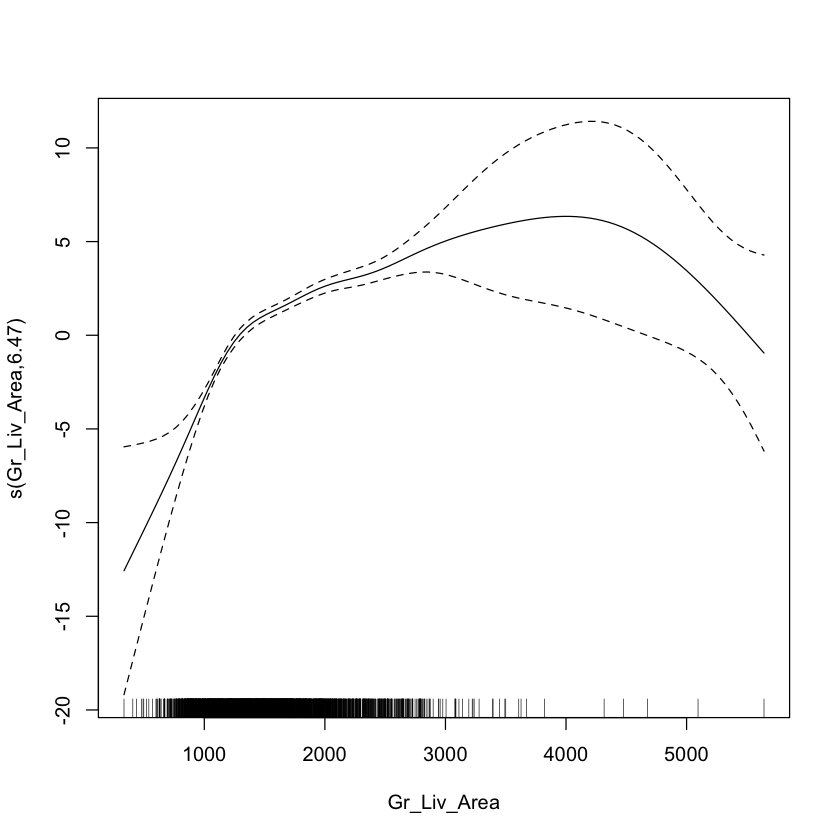

In [8]:
library(mgcv) 

# the 's' before Gr Liv Area is a spline function
fit.gam <- gam(Bonus ~ s(Gr_Liv_Area) + factor(Central_Air), 
 data = ames, family = binomial(link = 'logit'), method = 'REML') 

summary(fit.gam)

plot(fit.gam)

### Interpretation of the GLM summary:

- in the summary, look for the estimated degrees of freedom. This is an approximation for relationship with the logit. If it is edf = '1', then it is a straight line
- look for the GAM fit plot, and see if the line is straight.
- test these assumptions one variable at a time
- there is also a formal test: do a likelihood ration test on the spline model and the straight line model

### Checking GAM spline for linearity:

In [9]:
anova(logit.model, fit.gam, test = 'LRT')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2927.000,2529.895,NA,NA,NA
2,2921.527,2388.350,5.472611,141.5448,1.927384e-28


#### Interpretation:
- The low p-value of the spline comparison test leads us to reject the null hypothesis (that the two models are the 'same' - there is linearity).
- that means the assumption of linearity with the Logit for Gr Liv Area is NOT MET
- this makes sense: the edf in the summary for Gr Liv Area indicated a 6th order polynomial (6.22), which is not linear.

### What Happens when Assumptions Fail for a Continuous Variable?

- Use GAM logistic model (with more limited interpretation) for variables that break asssumption
- Or: bin it, and treat it as a Categorical  Variable. Keeps it interpretable, and this is the same as slicing it by the different groups.

### Binning example

In [10]:
ames <- ames %>%
 mutate(Gr_Liv_Area_BIN = cut(Gr_Liv_Area, 
 breaks = c(-Inf,1000,1500,3000,4500,Inf)))
logit.model.bin <- glm(Bonus ~ factor(Gr_Liv_Area_BIN) + factor(Central_Air), 
 data = ames, family = binomial(link = 'logit')) 
summary(logit.model.bin)


Call:
glm(formula = Bonus ~ factor(Gr_Liv_Area_BIN) + factor(Central_Air), 
    family = binomial(link = "logit"), data = ames)

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                             -8.4168     0.8132 -10.350  < 2e-16 ***
factor(Gr_Liv_Area_BIN)(1e+03,1.5e+03]   4.1172     0.7124   5.780 7.49e-09 ***
factor(Gr_Liv_Area_BIN)(1.5e+03,3e+03]   6.3156     0.7120   8.870  < 2e-16 ***
factor(Gr_Liv_Area_BIN)(3e+03,4.5e+03]  20.7939   303.4722   0.069    0.945    
factor(Gr_Liv_Area_BIN)(4.5e+03, Inf]    5.9210     1.4152   4.184 2.86e-05 ***
factor(Central_Air)Y                     3.1890     0.4013   7.946 1.93e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3983.5  on 2929  degrees of freedom
Residual deviance: 2704.4  on 2924  degrees of freedom
AIC: 2716.4

Number of Fisher Scoring iterations: 14


### Predicted Probabilities - Scoring a Model

- use 'new_data' as the proxy for the data you make predicitons on

In [11]:
new_ames <- data.frame(Gr_Liv_Area = c(1500, 2000, 2250, 2500, 3500), 
 Central_Air = c("N", "Y", "Y", "N", "Y")) 

new_ames <- data.frame(new_ames, 
 'Pred' = predict(logit.model, newdata = new_ames, 
 type = "response"))
 
print(new_ames)

  Gr_Liv_Area Central_Air       Pred
1        1500           N 0.01085182
2        2000           Y 0.87507486
3        2250           Y 0.95399645
4        2500           N 0.45732299
5        3500           Y 0.99978799


## Data Considerations

In [12]:
# correlation matrix and VIF/GVIF (between 5 and 10) for multicollinearity

### Rare Event Sampling - Over and Under
- Over: sampling more from the rare event. Use with small sample sizes
- Under: sampling less from the more common event. Use with large sample sizes

#### Oversampling

In [13]:
library(tidyverse) 

churn <- read.csv("https://raw.githubusercontent.com/IAA-Faculty/statistical_foundations/master/tele_churn2.csv")

table(churn$churn)


FALSE  TRUE 
 1671   154 

In [14]:
prop.table(table(churn$churn))


     FALSE       TRUE 
0.91561644 0.08438356 

In [15]:
churn$id <- 1:length(churn$churn)

In [16]:

set.seed(12345)

train_o <- churn %>% sample_frac(0.70)

# isolate and replicate the "event" cases, to oversample. We are replicating these observations
train_o_T <- train_o %>% filter(churn == TRUE) %>% slice(rep(1:n(), each = 10))

train_o_F <- train_o %>% filter(churn == FALSE)

train_o <- rbind(train_o_F, train_o_T)

test_o <- churn[-train_o$id,]

table(train_o$churn)


FALSE  TRUE 
 1170  1080 

#### Undersampling

In [17]:
library(tidyverse)

set.seed(12345)
train_u <- churn %>%
  group_by(churn) %>%
  sample_n(104)

test_u <- churn[-train_u$id,]

table(train_u$churn)


FALSE  TRUE 
  104   104 

### Build the Model - biased data, this model is wrong. Don't trust it, we will correct it.

In [18]:
head(churn)

,account.length,international.plan,voice.mail.plan,total.day.charge,total.intl.calls,customer.service.calls,churn,id
,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<lgl>,<int>
1,105,no,no,25.11,3,2,FALSE,1
2,50,no,yes,51.46,14,3,FALSE,2
3,118,no,no,23.14,4,1,FALSE,3
4,97,no,no,28.85,6,3,FALSE,4
5,51,no,no,38.62,2,0,FALSE,5
6,35,no,no,21.11,8,2,FALSE,6


In [19]:
logit.model <- glm(churn ~ factor(international.plan) +
                           factor(voice.mail.plan) +
                           total.day.charge +
                           customer.service.calls,
                   data = train_u, family = binomial(link = "logit"))
summary(logit.model)


Call:
glm(formula = churn ~ factor(international.plan) + factor(voice.mail.plan) + 
    total.day.charge + customer.service.calls, family = binomial(link = "logit"), 
    data = train_u)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -3.92612    0.79931  -4.912 9.02e-07 ***
factor(international.plan)yes  2.01842    0.48714   4.143 3.42e-05 ***
factor(voice.mail.plan)yes    -0.74297    0.39153  -1.898   0.0577 .  
total.day.charge               0.08065    0.01868   4.318 1.57e-05 ***
customer.service.calls         0.62730    0.12568   4.991 6.00e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 288.35  on 207  degrees of freedom
Residual deviance: 225.75  on 203  degrees of freedom
AIC: 235.75

Number of Fisher Scoring iterations: 4


### Repair Technique 1: Adjusting the Intercept to Repair the Oversampling
- ref: slide 14, here: file:///Users/frederik.lindsey/Downloads/Data%20Considerations.pdf

In [20]:
test_u_p_bias <- predict(logit.model, newdata = test_u, type = "response") 

test_u_p <- (test_u_p_bias*(104/208)*(154/3004))/
 ((1-test_u_p_bias)*(104/208)*(2850/3004) + 
 test_u_p_bias*(104/208)*(154/3004)) 

test_u <- data.frame(test_u, 
'Pred' = test_u_p) 

head(test_u_p)

1          2          3          4          5          6 
0.02753449 0.17439173 0.01273497 0.06689178 0.02344548 0.02009442

### Repair Technique 2: Weighting the Non-rare Events to Repair the Oversampling

In [21]:
train_u$weight <- ifelse(train_u$churn == 'TRUE', 1, 18.51) 

logit.model.w <- glm(churn ~ factor(international.plan) +
 factor(voice.mail.plan) +
 total.day.charge +
customer.service.calls, 
 data = train_u, family = binomial(link = "logit"), 
 weights = weight) 
 
summary(logit.model.w)


Call:
glm(formula = churn ~ factor(international.plan) + factor(voice.mail.plan) + 
    total.day.charge + customer.service.calls, family = binomial(link = "logit"), 
    data = train_u, weights = weight)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.78088    0.57468 -11.799  < 2e-16 ***
factor(international.plan)yes  1.71923    0.26171   6.569 5.06e-11 ***
factor(voice.mail.plan)yes    -1.04210    0.28816  -3.616 0.000299 ***
total.day.charge               0.08906    0.01493   5.965 2.44e-09 ***
customer.service.calls         0.50073    0.08174   6.126 9.03e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 820.53  on 207  degrees of freedom
Residual deviance: 694.64  on 203  degrees of freedom
AIC: 709.73

Number of Fisher Scoring iterations: 5


### Convergence Problems

In [22]:
table(train_u$customer.service.calls, train_u$churn)

   
    FALSE TRUE
  0    22   24
  1    42   23
  2    22   19
  3    15   10
  4     3   14
  5     0    9
  6     0    5

In [23]:
logit.model.w <- glm(churn ~ factor(international.plan) +
                               factor(voice.mail.plan) +
                               total.day.charge +
                               factor(customer.service.calls),
                     data = train_u, family = binomial(link = "logit"),
                     weights = weight)
summary(logit.model.w)


Call:
glm(formula = churn ~ factor(international.plan) + factor(voice.mail.plan) + 
    total.day.charge + factor(customer.service.calls), family = binomial(link = "logit"), 
    data = train_u, weights = weight)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -6.68786    0.65657 -10.186  < 2e-16 ***
factor(international.plan)yes     1.83349    0.29116   6.297 3.03e-10 ***
factor(voice.mail.plan)yes       -1.35541    0.32333  -4.192 2.76e-05 ***
total.day.charge                  0.11187    0.01663   6.728 1.72e-11 ***
factor(customer.service.calls)1  -0.64781    0.31614  -2.049  0.04045 *  
factor(customer.service.calls)2   0.14550    0.34375   0.423  0.67209    
factor(customer.service.calls)3  -0.52553    0.40049  -1.312  0.18945    
factor(customer.service.calls)4   1.09634    0.40235   2.725  0.00643 ** 
factor(customer.service.calls)5  20.13437  656.29470   0.031  0.97553    
factor(customer.service.calls)6

##### Soultion 1: Collapsing Categories
- Thresholding with an ordinal variable
- collapse low count variables into one category: eg 4+

##### Solution 2: Clustering Levels
- Use this for nominal variables
- combine the groups with most similar proportions (to minimize impact)
- Greenacre method: you lose more information by combining with a more different category than with a simlilar category

In [24]:
## combining categories
train_u$customer.service.calls.c <- as.character(train_u$customer.service.calls) 
train_u$customer.service.calls.c[which(train_u$customer.service.calls > 3)] <- "4+"
table(train_u$customer.service.calls.c, train_u$churn)

    
     FALSE TRUE
  0     22   24
  1     42   23
  2     22   19
  3     15   10
  4+     3   28

##### Solution 3: Penalized Maximum Likelihood
- use this when we have a binary with a 0. Can't combine it.
- use the brglm() function

### Variable selection in Logistic Regression

#### Stepwise

In [25]:
library(AmesHousing) 
library(tidyverse) 
ames <- make_ordinal_ames()
ames <- ames %>%
 mutate(Bonus = ifelse(Sale_Price > 175000, 1, 0))

In [26]:
# full model
full.model <- glm(Bonus ~ Gr_Liv_Area + factor(House_Style) + Garage_Area +
 Fireplaces + factor(Full_Bath) + factor(Half_Bath) +
 Lot_Area + factor(Central_Air) + Second_Flr_SF +
 TotRms_AbvGrd + First_Flr_SF, 
 data = ames, family = binomial(link = "logit"))

#empty mdoel
empty.model <- glm(Bonus ~ 1, 
 data = ames, family = binomial(link = "logit")) 

# step model is indicated by direction = both. Uses AIC by default.
step.model <- step(empty.model, 
 scope = list(lower=formula(empty.model), 
 upper=formula(full.model)), 
 direction = "both")

Start:  AIC=3985.51
Bonus ~ 1

                      Df Deviance    AIC
+ Gr_Liv_Area          1   2697.6 2701.6
+ factor(Full_Bath)    4   2738.8 2748.8
+ Garage_Area          1   3045.2 3049.2
+ First_Flr_SF         1   3259.6 3263.6
+ Fireplaces           1   3481.6 3485.6
+ TotRms_AbvGrd        1   3496.5 3500.5
+ factor(House_Style)  7   3635.2 3651.2
+ factor(Half_Bath)    2   3740.5 3746.5
+ Lot_Area             1   3750.1 3754.1
+ Second_Flr_SF        1   3768.8 3772.8
+ factor(Central_Air)  1   3818.4 3822.4
<none>                     3983.5 3985.5

Step:  AIC=2701.55
Bonus ~ Gr_Liv_Area

                      Df Deviance    AIC
+ Garage_Area          1   2348.5 2354.5
+ factor(Full_Bath)    4   2356.3 2368.3
+ factor(House_Style)  7   2354.0 2372.0
+ factor(Central_Air)  1   2529.9 2535.9
+ First_Flr_SF         1   2541.4 2547.4
+ Second_Flr_SF        1   2562.4 2568.4
+ TotRms_AbvGrd        1   2566.5 2572.5
+ Fireplaces           1   2609.9 2615.9
+ factor(Half_Bath)    2  

In [27]:
summary(step.model)


Call:
glm(formula = Bonus ~ Gr_Liv_Area + Garage_Area + factor(Full_Bath) + 
    Fireplaces + factor(House_Style) + factor(Half_Bath) + TotRms_AbvGrd + 
    factor(Central_Air) + Lot_Area, family = binomial(link = "logit"), 
    data = ames)

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -7.996e+00  1.335e+00  -5.988 2.12e-09 ***
Gr_Liv_Area                          4.186e-03  3.534e-04  11.843  < 2e-16 ***
Garage_Area                          3.603e-03  4.421e-04   8.150 3.64e-16 ***
factor(Full_Bath)1                  -1.215e+00  1.186e+00  -1.025 0.305438    
factor(Full_Bath)2                   1.443e+00  1.195e+00   1.208 0.227172    
factor(Full_Bath)3                   2.490e+00  1.351e+00   1.843 0.065282 .  
factor(Full_Bath)4                  -1.289e+00  2.351e+00  -0.548 0.583431    
Fireplaces                           8.578e-01  1.082e-01   7.926 2.26e-15 ***
factor(House_Style)One_and_Half

#### Backward

In [28]:
full.model <- glm(Bonus ~ Gr_Liv_Area + factor(House_Style) + Garage_Area +
 Fireplaces + factor(Full_Bath) + factor(Half_Bath) +
 Lot_Area + factor(Central_Air) + Second_Flr_SF +
 TotRms_AbvGrd + First_Flr_SF, 
 data = ames, family = binomial(link = "logit")) 

back.model <- step(full.model, direction = "backward")

summary(back.model)

Start:  AIC=1717.35
Bonus ~ Gr_Liv_Area + factor(House_Style) + Garage_Area + Fireplaces + 
    factor(Full_Bath) + factor(Half_Bath) + Lot_Area + factor(Central_Air) + 
    Second_Flr_SF + TotRms_AbvGrd + First_Flr_SF

                      Df Deviance    AIC
- Gr_Liv_Area          1   1673.5 1715.5
<none>                     1673.3 1717.3
- Lot_Area             1   1675.5 1717.5
- Second_Flr_SF        1   1678.9 1720.9
- First_Flr_SF         1   1680.0 1722.0
- factor(Central_Air)  1   1689.2 1731.2
- factor(House_Style)  7   1727.5 1757.5
- TotRms_AbvGrd        1   1726.7 1768.7
- factor(Half_Bath)    2   1733.2 1773.2
- Fireplaces           1   1735.4 1777.4
- Garage_Area          1   1740.5 1782.5
- factor(Full_Bath)    4   1959.5 1995.5

Step:  AIC=1715.5
Bonus ~ factor(House_Style) + Garage_Area + Fireplaces + factor(Full_Bath) + 
    factor(Half_Bath) + Lot_Area + factor(Central_Air) + Second_Flr_SF + 
    TotRms_AbvGrd + First_Flr_SF

                      Df Deviance    AIC
<


Call:
glm(formula = Bonus ~ factor(House_Style) + Garage_Area + Fireplaces + 
    factor(Full_Bath) + factor(Half_Bath) + Lot_Area + factor(Central_Air) + 
    Second_Flr_SF + TotRms_AbvGrd + First_Flr_SF, family = binomial(link = "logit"), 
    data = ames)

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -8.192e+00  1.354e+00  -6.050 1.45e-09 ***
factor(House_Style)One_and_Half_Fin -2.331e+00  4.172e-01  -5.589 2.29e-08 ***
factor(House_Style)One_and_Half_Unf -1.107e+01  3.057e+02  -0.036 0.971115    
factor(House_Style)SFoyer           -8.068e-01  5.041e-01  -1.600 0.109492    
factor(House_Style)SLvl             -1.367e+00  3.499e-01  -3.908 9.32e-05 ***
factor(House_Style)Two_Story        -1.301e+00  4.432e-01  -2.935 0.003336 ** 
factor(House_Style)Two_and_Half_Fin  1.842e+00  1.974e+00   0.933 0.350707    
factor(House_Style)Two_and_Half_Unf -1.571e+00  7.951e-01  -1.976 0.048200 *  
Garage_Area   

### Forward Selection

#### Why?
- better for checking for Quasi-Complete separation
- Process: tons of variables and interactions: 1. whittle down variable list (w/o interactions) , 2. Build back up with interactions
- is this approach perfect: no, but it is very efficient and captures most of what we need to know

### P-Value vs. AIC Selection

### Diagnostics - Influence Statitics

In [29]:
library(car) 

logit.model <- glm(Bonus ~ Gr_Liv_Area + factor(House_Style) + Garage_Area +
 Fireplaces + factor(Full_Bath) + Lot_Area +
 factor(Central_Air) + TotRms_AbvGrd +
 Gr_Liv_Area:Fireplaces, 
 data = ames, family = binomial(link = "logit"))

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




### Cooke's D: the fourth in the plot series

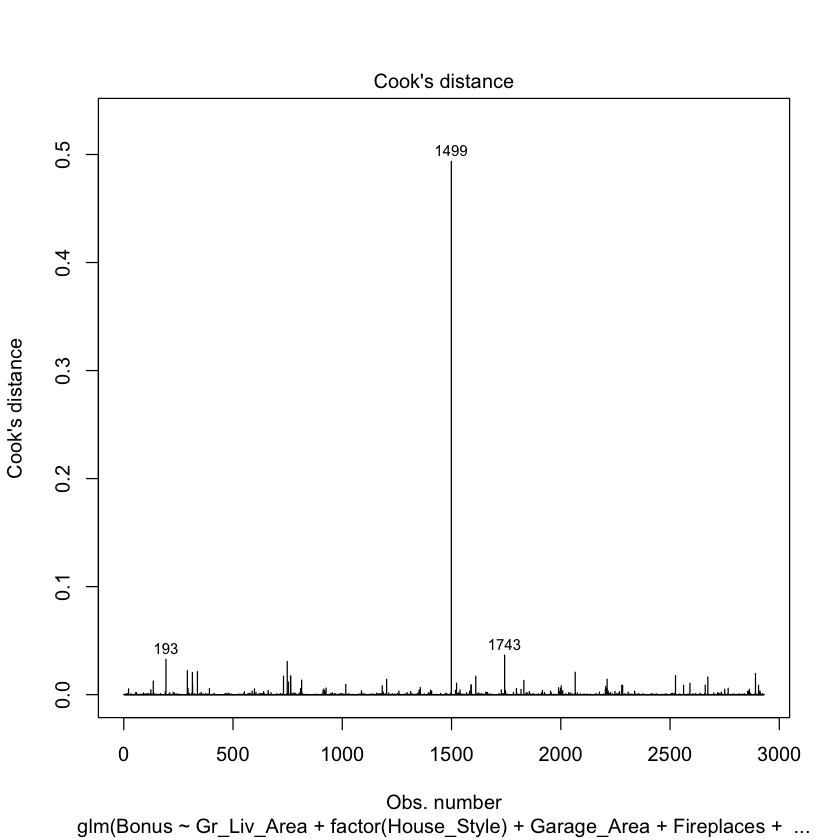

In [30]:
plot(logit.model, 4)

### DFBetas

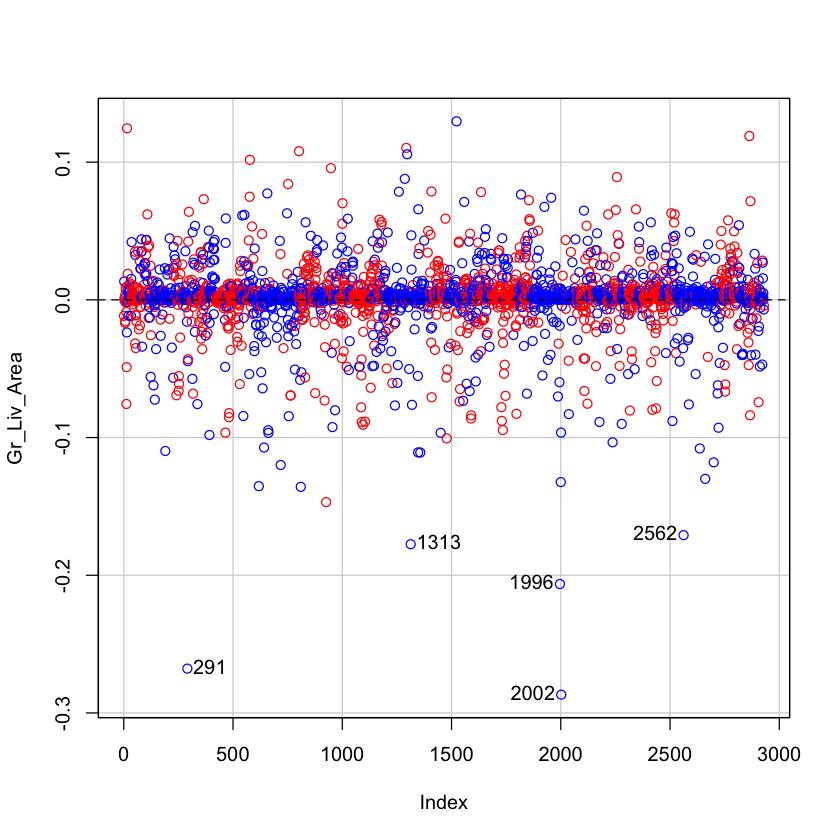

In [31]:
dfbetasPlots(logit.model, terms = "Gr_Liv_Area"
, id.n = 5, 
 col = ifelse(logit.model$y == 1, "red", "blue"))

## Model Assessment

In [56]:
library(DescTools)

Warning message:
"package 'DescTools' was built under R version 4.4.1"

Attaching package: 'DescTools'


The following objects are masked from 'package:Hmisc':

    %nin%, Label, Mean, Quantile


The following object is masked from 'package:car':

    Recode




In [57]:
AIC(logit.model)

BIC(logit.model)

PseudoR2(logit.model, which = "Nagelkerke")



[1] 1776.633

[1] 1890.305

Nagelkerke 
 0.7201176

#### Coefficient of Discrimination

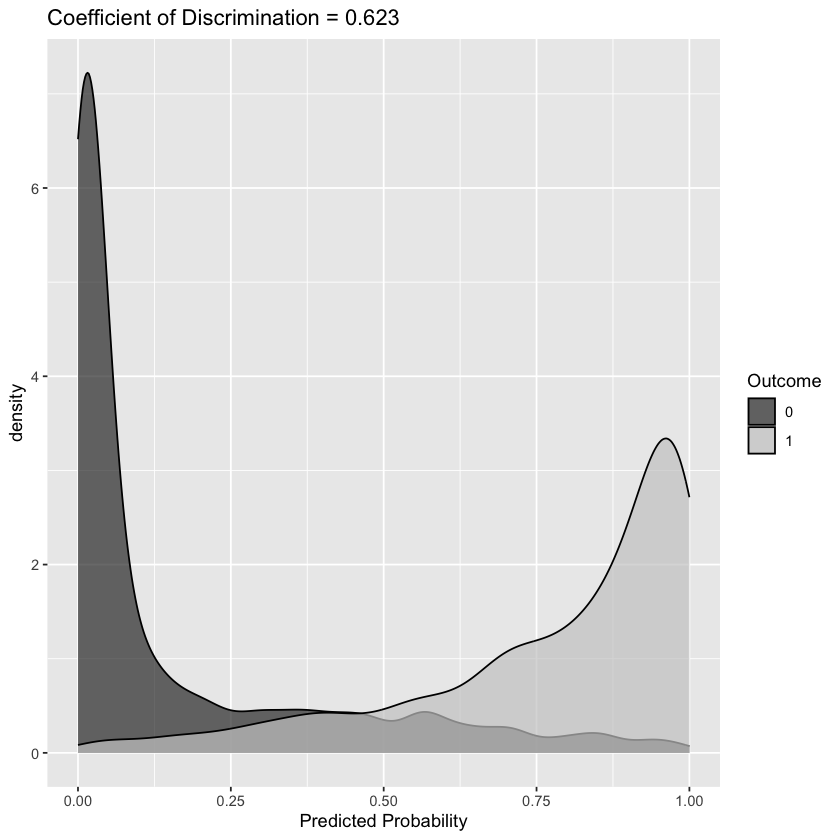

In [58]:
ames$p_hat <- predict(logit.model, type = "response") 
p1 <- ames$p_hat[ames$Bonus == 1] 
p0 <- ames$p_hat[ames$Bonus == 0] 
coef_discrim <- mean(p1) - mean(p0)
ggplot(ames, aes(p_hat, fill = factor(Bonus))) + geom_density(alpha = 0.7) + scale_fill_grey() + labs(x = "Predicted Probability", fill = "Outcome", title = paste("Coefficient of Discrimination = ", 
 round(coef_discrim, 3), sep = ""))

#### Concordance

In [59]:
library(Hmisc) 
somers2(ames$p_hat, ames$Bonus)

C          Dxy            n      Missing 
   0.9461446    0.8922892 2930.0000000    0.0000000

### Classification Table/Confusion Matrix

In [60]:
ames <- ames %>% mutate(Bonus_hat = ifelse(p_hat > 0.5, 1, 0))

table(ames$Bonus_hat, train$Bonus)

   
       0    1
  0 1497  171
  1  207 1055

In [61]:
install.packages("ROCit")


The downloaded binary packages are in
	/var/folders/2g/7wbchb2s0wvgd6gwy4w7vlch0000gn/T//RtmpO9PsyL/downloaded_packages


### ROC Curve/ AUC (Health Care)

In [62]:
library(ROCit) 
logit_meas <- measureit(ames$p_hat, ames$Bonus, measure = c('ACC','SENS','SPEC'))
print(logit_meas)

           Cutoff        Depth   TP   FP   TN   FN       ACC         SENS
1             Inf 0.0000000000    0    0 1704 1226 0.5815700 0.0000000000
2    1.000000e+00 0.0003412969    0    1 1703 1226 0.5812287 0.0000000000
3    9.999993e-01 0.0006825939    1    1 1703 1225 0.5815700 0.0008156607
4    9.999993e-01 0.0010238908    2    1 1703 1224 0.5819113 0.0016313214
5    9.999974e-01 0.0013651877    3    1 1703 1223 0.5822526 0.0024469821
6    9.999959e-01 0.0017064846    4    1 1703 1222 0.5825939 0.0032626427
7    9.999786e-01 0.0020477816    5    1 1703 1221 0.5829352 0.0040783034
8    9.999590e-01 0.0023890785    6    1 1703 1220 0.5832765 0.0048939641
9    9.999476e-01 0.0027303754    7    1 1703 1219 0.5836177 0.0057096248
10   9.999249e-01 0.0030716724    8    1 1703 1218 0.5839590 0.0065252855
11   9.998909e-01 0.0034129693    9    1 1703 1217 0.5843003 0.0073409462
12   9.998820e-01 0.0037542662   10    1 1703 1216 0.5846416 0.0081566069
13   9.998786e-01 0.0040955631   11   

In [63]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude,Bonus,p_hat,Bonus_hat
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<ord>,<ord>,<ord>,<fct>,...,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,5,2010,WD,Normal,215000,-93.61975,42.05403,1,0.65685664,1
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,6,2010,WD,Normal,105000,-93.61976,42.05301,0,0.04598453,0
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,6,2010,WD,Normal,172000,-93.61939,42.05266,0,0.04372246,0
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,4,2010,WD,Normal,244000,-93.61732,42.05125,1,0.97771974,1
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,3,2010,WD,Normal,189900,-93.63893,42.06090,1,0.82012098,1
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,6,2010,WD,Normal,195500,-93.63893,42.06078,1,0.67868552,1


In [64]:
unique(ames$Bonus)

[1] 1 0

In [65]:
any(is.na(ames$Bonus))


[1] FALSE

#### Get the Youdin Index

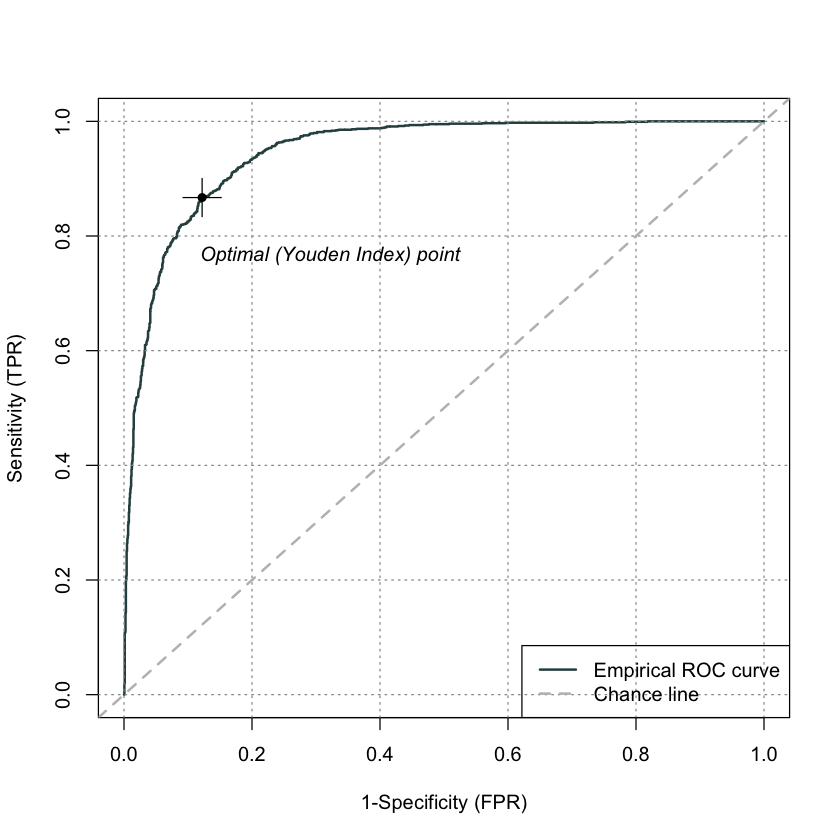

In [74]:
logit_roc <- rocit(ames$p_hat, ames$Bonus)
plot(logit_roc)

#### Get the optimal point in R

value       FPR       TPR    cutoff 
0.7449816 0.1220657 0.8670473 0.4909878

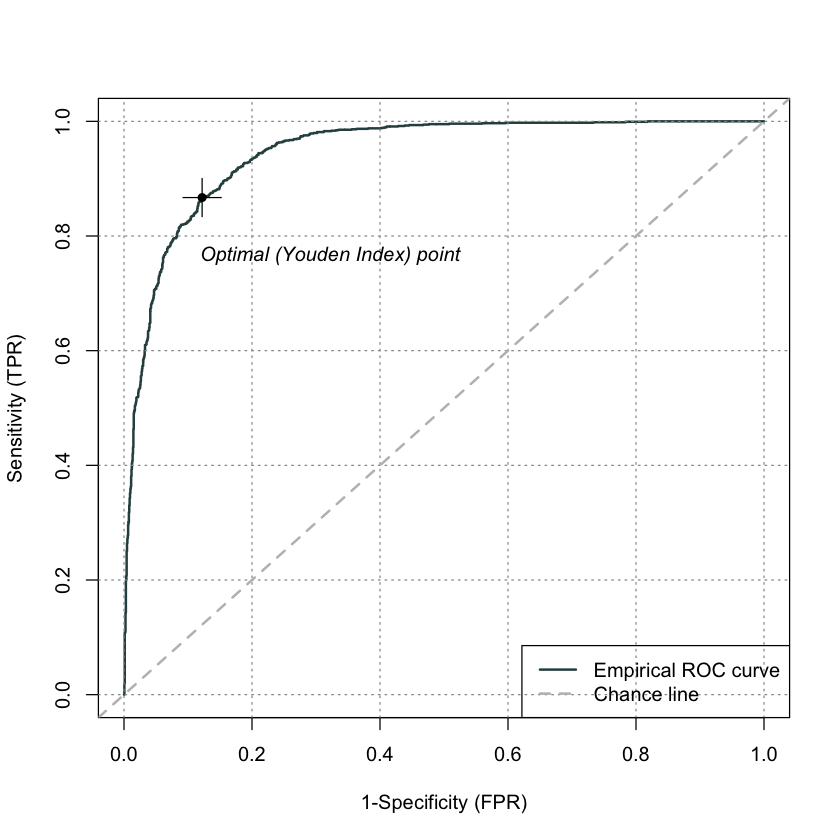

In [75]:
plot(logit_roc)$optimal

### ROC Summary

In [76]:
summary(logit_roc)

                            
 Method used: empirical     
 Number of positive(s): 1226
 Number of negative(s): 1704
 Area under curve: 0.9461   


### Method 2: KS Statistic (Banking)

NULL

[1] 0.4909878

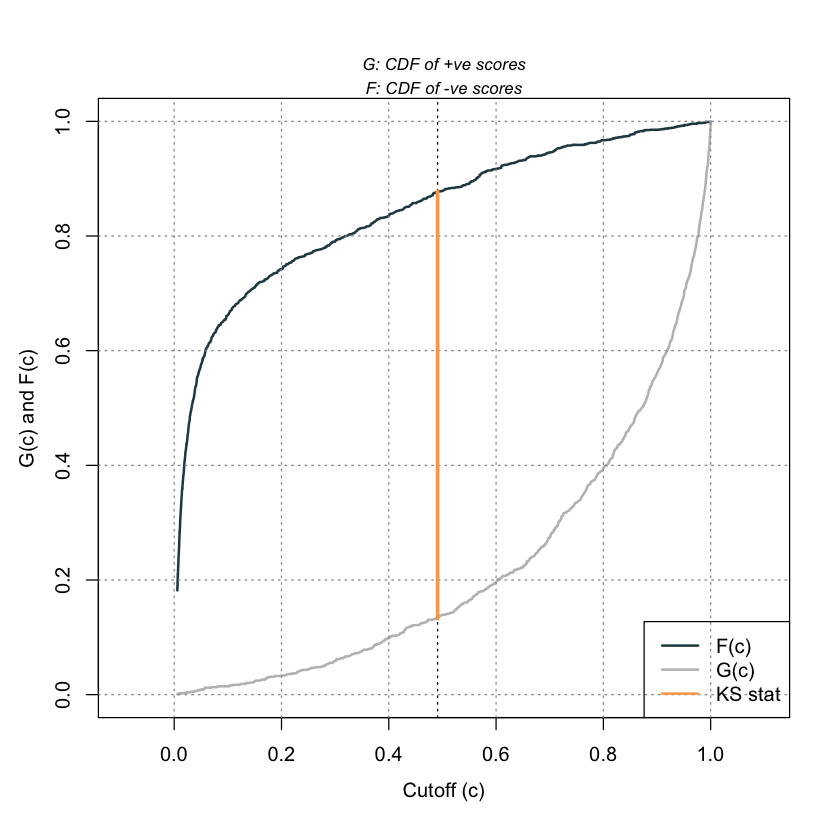

In [77]:
ksplot(logit_roc)

ksplot(logit_roc)$`KS Stat`

ksplot(logit_roc)$`KS Cutoff`
